## Objective of this notebook
To explore a dataset about body performance and deep learning learning models to classify performers. <br>
The results would be compared to a reference simple k-Nearest Neighbour classification.

## Source of dataset
From Kaggle: [Body Performance Data](https://www.kaggle.com/datasets/kukuroo3/body-performance-data) <br>
Features are body performance measurements. The 4 classes (A,B,C,D) are targets.

<h2> Exploratory Data Analysis </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<p> <strong>Basic information</strong> of the dataset</p>

In [2]:
df = pd.read_csv('bodyperformance.csv')
print('Dataset shape:',df.shape)
print('Datatypes:', df.dtypes.unique())
print('With null values:',df.isnull().values.any())

Dataset shape: (13393, 12)
Datatypes: [dtype('float64') dtype('O')]
With null values: False


In [3]:
df.head(3)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [5]:
df.rename(columns={'sit and bend forward_cm':'sit-bend_cm'}, inplace=True)

In [6]:
df['class'].value_counts()

C    3349
D    3349
A    3348
B    3347
Name: class, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,13393.0,36.775106,13.625639,21.0,25.0,32.0,48.0,64.0
height_cm,13393.0,168.559807,8.426583,125.0,162.4,169.2,174.8,193.8
weight_kg,13393.0,67.447316,11.949666,26.3,58.2,67.4,75.3,138.1
body fat_%,13393.0,23.240165,7.256844,3.0,18.0,22.8,28.0,78.4
diastolic,13393.0,78.796842,10.742033,0.0,71.0,79.0,86.0,156.2
systolic,13393.0,130.234817,14.713954,0.0,120.0,130.0,141.0,201.0
gripForce,13393.0,36.963877,10.624864,0.0,27.5,37.9,45.2,70.5
sit-bend_cm,13393.0,15.209268,8.456677,-25.0,10.9,16.2,20.7,213.0
sit-ups counts,13393.0,39.771224,14.276698,0.0,30.0,41.0,50.0,80.0
broad jump_cm,13393.0,190.129627,39.868000,0.0,162.0,193.0,221.0,303.0


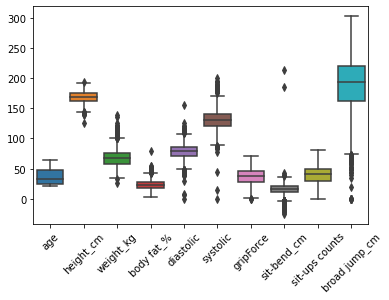

In [8]:
sns.boxplot(data=df.select_dtypes('float64'))
plt.tick_params(axis='x', rotation=45)

There are **doubtful measurements**.  They are rather incorrect in nautre than just outliers, which the latter could be spotted by some clustering algorithms.<br>
- zero or very low diastolic / systolic
- extremely large or negative sit-bend

It is likely that the extreme sit-bends are typos i.e. 21.3 cm instead of 213 cm (taller than the person)

In [9]:
df['diastolic'].sort_values()[:7]

10624     0.0
3524      6.0
336       8.0
6786     30.0
344      37.0
6234     40.0
12698    41.0
Name: diastolic, dtype: float64

In [10]:
df['systolic'].sort_values()[:7]

10624     0.0
7597     14.0
8217     43.9
344      77.0
7341     82.0
9440     84.0
4412     86.0
Name: systolic, dtype: float64

In [11]:
extreme = df[(df['diastolic']<30) | 
             (df['systolic']<77) | (df['sit-bend_cm'] >= 100)]
extreme

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit-bend_cm,sit-ups counts,broad jump_cm,class
336,35.0,M,173.1,77.60,22.8,8.0,122.0,46.4,16.7,47.0,216.0,B
2657,33.0,M,165.6,60.40,17.8,81.0,127.0,38.6,213.0,53.0,244.0,B
3355,45.0,M,164.4,64.40,24.3,96.0,142.0,38.5,185.0,44.0,223.0,A
3524,44.0,M,177.0,78.28,22.1,6.0,145.0,47.4,10.5,42.0,215.0,B
7597,30.0,M,166.6,66.08,14.4,67.0,14.0,53.8,17.2,57.0,221.0,A
8217,31.0,M,176.7,80.32,20.8,46.2,43.9,43.9,17.2,57.0,221.0,B
10624,26.0,F,160.0,63.56,32.0,0.0,0.0,23.7,17.1,23.0,128.0,D


In [12]:
df = df.drop(extreme.index).reset_index(drop=True)

On the other hand, there are 642 rows in the negative sit-bend.

In [13]:
print('feature / zero / negative')
for col in ['sit-bend_cm','gripForce','sit-ups counts','broad jump_cm']:
    print(col, df[df[col] == 0].shape[0], df[df[col] < 0].shape[0])

feature / zero / negative
sit-bend_cm 12 642
gripForce 3 0
sit-ups counts 125 0
broad jump_cm 10 0


The rows of negative sit-bend are dropped since there is no information on how it was measured. 

In [14]:
#drop negative sit-bend
extreme2 = df[df['sit-bend_cm'] < 0]
df = df.drop(extreme2.index).reset_index(drop=True)

In [15]:
#obtaining the 1.5IQR for a column
def iqr(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3-q1
    return q1-1.5*iqr, q3+1.5*iqr

(12395, 12)


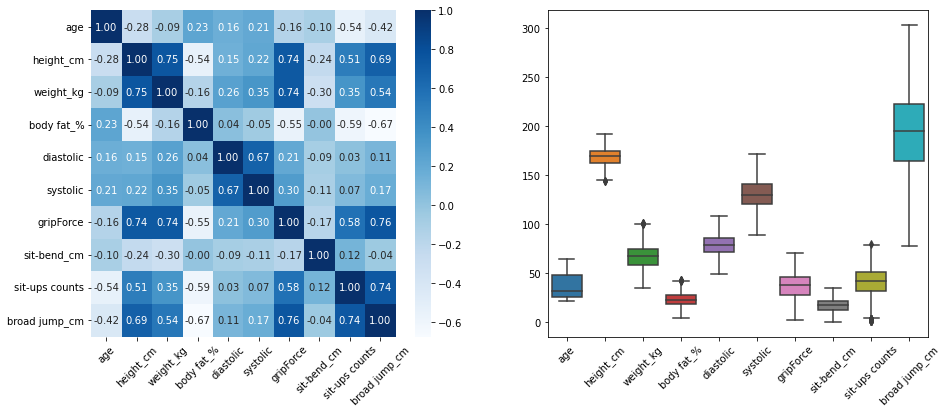

In [16]:
for col in df.drop(['age','gender','class'], axis=1).columns:
    lq, uq = iqr(df[col])
    df = df[(df[col] >= lq) & (df[col] <= uq)]
print(df.shape)

fig, ax = plt.subplots(1,2, figsize=(15,6))
p1 = sns.heatmap(df.select_dtypes('float64').corr(), annot=True, fmt='.2f', ax=ax[0], cmap='Blues')
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)

p2 = sns.boxplot(data=df, ax=ax[1])
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

fig.show()

## Feature Selection and Engineering

Focusing on the performance, **age**, **height**, and **weight** are dropped.

In [17]:
df = df.drop(['age','height_cm','weight_kg'], axis=1)

In respect of **gender**, which is a **categorical feature**, the following analysis roughly suggests that the two genders have different means of performance (such as broad jump) and body measurements (height and weight).

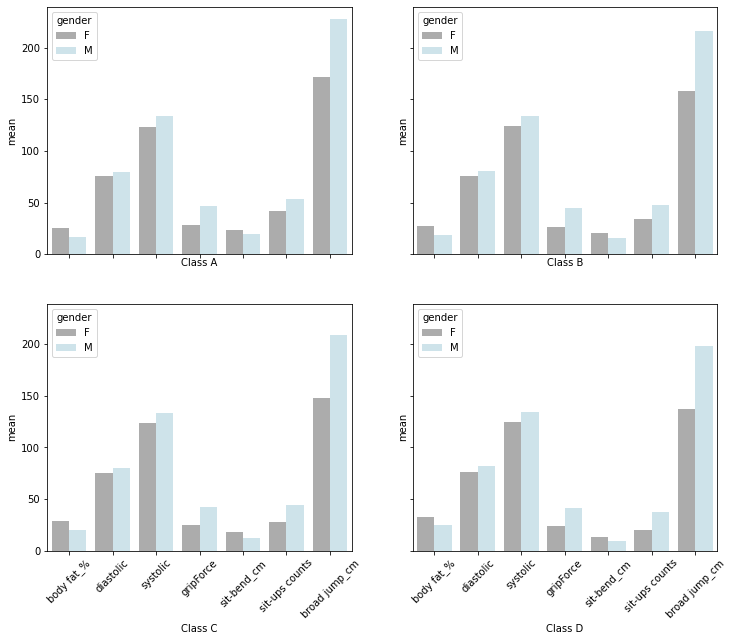

In [18]:
fig, ax = plt.subplots(2,2,figsize=(12,10),sharey=True,sharex=True)
axes = ax.flatten()
for idx, cla in enumerate(['A','B','C','D']):
    df_class = df[df['class']==cla].groupby('gender').mean() \
                                .unstack() \
                                .reset_index() \
                                .rename(columns={'level_0':'attribute',0:'mean'})
    
    sns.barplot(x='attribute',y='mean',hue='gender',data=df_class, 
                ax=axes[idx], palette=['grey','lightblue'], alpha=0.65)    
    
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xlabel('Class {}'.format(cla))

Female and male also have different proportion of classes and performance.

In [19]:
df.groupby(['gender'])['class'].value_counts(normalize=True) \
    .to_frame().rename(columns={'class':'proportion'}).sort_values(['gender','class'])

proportion
gender class            
F      A        0.320837
       B        0.255231
       C        0.239102
       D        0.184830
M      A        0.235942
       B        0.274497
       C        0.284616
       D        0.204944

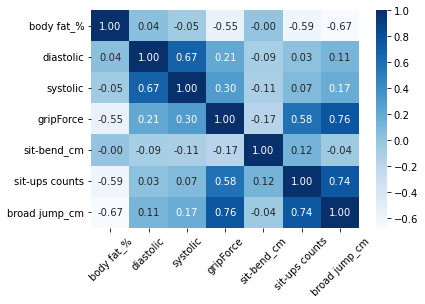

In [20]:
p3 = sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Blues')
p3.set_xticklabels(p3.get_xticklabels(), rotation=45)
fig.show()

Some features are quite correlated - diastolic and systolic pressures are understandable, sit-ups and broad jump probably reflect the physical strength. The following analysis uses all the seven features and all genders.

From here the features and target are obtained.

In [21]:
x, y = df.drop(['gender','class'], axis=1), df['class'] 

<h2> Model Training </h2>

### Reference Model - KNN

A rough KNN model is trained to compare with the DL model

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, accuracy_score

First perform **Standard scaling** to ensure all features share the same scale for calculating the distance.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

In [24]:
s = StandardScaler()
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [25]:
knn = KNN(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.54      0.75      0.63       984
           B       0.41      0.42      0.41      1009
           C       0.52      0.45      0.48       990
           D       0.76      0.49      0.59       736

    accuracy                           0.53      3719
   macro avg       0.56      0.53      0.53      3719
weighted avg       0.54      0.53      0.53      3719



### Neural Network

A couple of models are developed gradually with fine-tuning on activation function, optimiser and regularisation. 

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop

#### Pre-processing

First map classes A to D into 0-3

In [28]:
_, train_labels = np.unique(y_train, return_inverse=True)
_, test_labels = np.unique(y_test, return_inverse=True)

doublechecking

In [29]:
np.unique(y_train,return_counts=True)

(array(['A', 'B', 'C', 'D'], dtype=object),
 array([2330, 2305, 2329, 1712], dtype=int64))

In [30]:
np.unique(train_labels,return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([2330, 2305, 2329, 1712], dtype=int64))

#### Model generator
To define a model generator with different numbers of hidden layers/nodes, activation functions, and optimisers

In [31]:
epochs = 400

In [32]:
def genmodel(n_layer, n_node, activation, optimiser, lr=0.0002):
    model = Sequential()
    
    #input layer to match input shape of 7 features
    model.add(Dense(n_node, activation=activation, input_shape=(7,)))
    
    #add n_layer no. of Dense layers
    for i in range(n_layer):
        model.add(Dense(n_node, activation=activation))
        
    #output layer for 4 classes
    model.add(Dense(4, activation='softmax'))
    
    model.summary()
    
    #compile model
    model.compile(optimiser(lr=lr), 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Also define a run function

In [33]:
def run(model):

    model_run = model.fit(x_train, train_labels, validation_data = (x_test, test_labels), 
                          batch_size=32, epochs=epochs, verbose=0)
    return model_run

#### Model 1 - Two hidden layers with 20 nodes, sigmoid as activation

In [34]:
model1 = genmodel(2, 20, 'sigmoid', SGD)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                160       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


In [35]:
model1_run = run(model1)

In [36]:
print('Model1\'s accurary on testing set:', model1.evaluate(x_test, test_labels)[1])

117/117 [==============================] - 0s 896us/step - loss: 1.3733 - accuracy: 0.3934
Model1's accurary on testing set: 0.3933853209018707


It is worse than rough KNN model.

#### Model 2 - Two hidden layers with 20 nodes, ReLU as activation

In [37]:
model2 = genmodel(2, 20, 'relu', SGD)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                160       
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 4)                 84        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


In [38]:
model2_run = run(model2)

In [39]:
print('Model2\'s accurary on testing set:', model2.evaluate(x_test, test_labels)[1])

117/117 [==============================] - 0s 884us/step - loss: 1.0052 - accuracy: 0.5440
Model2's accurary on testing set: 0.5439634323120117


Activation using ReLU achieves better testing accurarcy than sigmoid.

#### Model 3 - Two hidden layers with 20 nodes, Adam as optimiser

In [40]:
model3 = genmodel(2, 20, 'relu', Adam)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                160       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 4)                 84        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


In [41]:
model3_run = run(model3)

In [42]:
print('Model3\'s accurary on testing set:', model3.evaluate(x_test, test_labels)[1])

117/117 [==============================] - 0s 968us/step - loss: 0.9029 - accuracy: 0.5924
Model3's accurary on testing set: 0.5923635363578796


Adam performs a bit better than SGD.

#### Model 4 - Two hidden layers with 20 nodes, RMSprop as optimser

In [43]:
model4 = genmodel(2, 20, 'relu', RMSprop)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                160       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 4)                 84        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


In [44]:
model4_run = run(model4)

In [45]:
print('Model4\'s accurary on testing set:', model4.evaluate(x_test, test_labels)[1])

117/117 [==============================] - 0s 921us/step - loss: 0.9192 - accuracy: 0.5856
Model4's accurary on testing set: 0.5856413245201111


RMSprop performs very close to Adam, which is also a bit better than SGD.

#### Model 5 - Two dense layers each followed by a dropout layer

Base on model3, a dropout layer is added to each dense layer to see whether the accuracy can be improved.

In [46]:
model5 = Sequential()
model5.add(Dense(20, activation='relu', input_shape=(7,)))
model5.add(Dense(20, activation='relu'))
model5.add(Dropout(rate=0.2)) #Dropout layer added
model5.add(Dense(20, activation='relu'))
model5.add(Dropout(rate=0.2)) #Dropout layer added
model5.add(Dense(4, activation='softmax'))
    
model5.summary()
model5.compile(Adam(lr=0.0002), 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                160       
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 4)                 84        
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-traina

In [47]:
model5_run = run(model5)

In [48]:
print('Model5\'s accurary on testing set:', model5.evaluate(x_test, test_labels)[1])

117/117 [==============================] - 0s 913us/step - loss: 0.9058 - accuracy: 0.5951
Model5's accurary on testing set: 0.5950524210929871


Regularisation improves the accuracy a bit.

<h3> Model Evaluation </h3>

The validation accuracies of different models are plotted.

<AxesSubplot:>

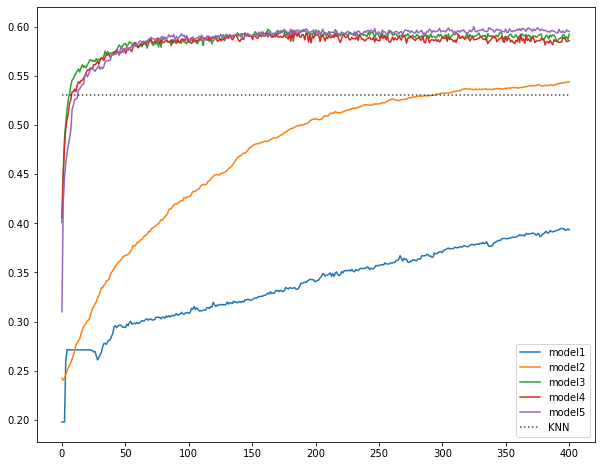

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
models = [model1_run, model2_run, model3_run, model4_run, model5_run]
colors = sns.color_palette()
for i, model in enumerate(models):
    sns.lineplot(np.linspace(0,epochs,epochs), model.history['val_accuracy'], ls='-', color=colors[i], label='model{}'.format(str(i+1)))
    
sns.lineplot(np.linspace(0,epochs,epochs), y=0.53, ls=':', color='k', alpha=0.7, label='KNN')

Model1 performs much worse than the reference rough KNN because sigmoid is used as activation. It is evidenced by Model2 where ReLU is used keeping other hyperparameters unchanged. Model2 performs better than KNN at when more epochs are run.

Model3 and Model4 suggest Adam/RMSprop perform better than SGD (Model1 and Model2).  Using Adam or RMSprop as optimiser only differ a little bit.

Regularisation improves a bit in model performance. **Model5** performs the best in this regard.

The accuracies seem to plateau at 0.6 or at about 60%. More epochs may not bring much improvement in this regard.

In [51]:
y_nn_pred = model5.predict(x_test)

117/117 [==============================] - 0s 756us/step


In [52]:
d = {0:'A', 1:'B', 2:'C', 3:'D'}
y_nn = np.array(list(map(lambda p : d[np.argmax(p)], y_nn_pred)))

In [53]:
print(classification_report(y_test, y_nn))

              precision    recall  f1-score   support

           A       0.60      0.85      0.70       984
           B       0.48      0.42      0.44      1009
           C       0.58      0.52      0.55       990
           D       0.79      0.61      0.69       736

    accuracy                           0.60      3719
   macro avg       0.61      0.60      0.60      3719
weighted avg       0.60      0.60      0.59      3719



<h2> Summary </h2>

From the above analysis, the **best model** in prediction is **Model5** of four hidden layers comprising **two dense layers each followed by a dropout layer** as **regularisation**. The model adopts **Adam as optimiser** and **ReLU as activation function**. The model is trained at a learning rate of 0.0002 and on 400 epochs. The accuracy seems to plateau at about 60%. More epochs may not bring much improvement in this regard.

The best model could achieve about **60% overall accuracy**, which is **slightly better** than a rough **k-nearest neighbour at 53%**.

The best model is good at predicting classes A and D but moderately on classes B and C.

**Possible Improvements** 

The authenticity of original dataset may be improved by **clarification of further suspected (and dropped) outliers**.
**More layers or regularisation** may be deployed to refine the model.

The analysis may be carried out for **different genders**. As in the EDA section, the two genders have **different means of performance in this dataset**.